In [1]:
import openslide
import numpy as np
import os
import matplotlib.pyplot as plt
# Simple full slide visualization
from PIL import Image


In [2]:
def crop_white_background(image, threshold=240, margin_percent=5):
    """
    Crop white background from an image while keeping a safety margin.
    
    Parameters:
    -----------
    image : numpy array
        Input image (RGB or RGBA)
    threshold : int
        Grayscale threshold to consider as "white" (default: 240)
        Pixels with all RGB values > threshold are considered background
    margin_percent : int
        Percentage of the tissue bounding box to add as margin (default: 5%)
        
    Returns:
    --------
    cropped_image : numpy array
        Cropped image with white background removed
    crop_coords : tuple
        (top, bottom, left, right) coordinates used for cropping
    """
    # Convert to grayscale for tissue detection
    if image.shape[2] == 4:  # RGBA
        gray = np.mean(image[:, :, :3], axis=2)
    else:  # RGB
        gray = np.mean(image, axis=2)
    
    # Create tissue mask (not white)
    tissue_mask = gray < threshold
    
    # Find rows and columns with tissue
    rows_with_tissue = np.any(tissue_mask, axis=1)
    cols_with_tissue = np.any(tissue_mask, axis=0)
    
    # Get bounding box of tissue
    top = np.argmax(rows_with_tissue)
    bottom = len(rows_with_tissue) - np.argmax(rows_with_tissue[::-1])
    left = np.argmax(cols_with_tissue)
    right = len(cols_with_tissue) - np.argmax(cols_with_tissue[::-1])
    
    # Add margin (as percentage of tissue size)
    height = bottom - top
    width = right - left
    margin_h = int(height * margin_percent / 100)
    margin_w = int(width * margin_percent / 100)
    
    # Apply margin with bounds checking
    top = max(0, top - margin_h)
    bottom = min(image.shape[0], bottom + margin_h)
    left = max(0, left - margin_w)
    right = min(image.shape[1], right + margin_w)
    
    # Crop the image
    cropped = image[top:bottom, left:right]
    
    print(f"  Original size: {image.shape[0]}x{image.shape[1]}")
    print(f"  Tissue bounding box: rows {top}-{bottom}, cols {left}-{right}")
    print(f"  Cropped size: {cropped.shape[0]}x{cropped.shape[1]}")
    print(f"  Margin added: {margin_h} rows, {margin_w} cols ({margin_percent}%)")
    
    return cropped, (top, bottom, left, right)



In [3]:
def process_dual_tissue_slide(slide_path, thumbnail_size=(5000, 5000), 
                              threshold=240, margin_percent=5, verbose=True):
    """
    Process a whole slide image containing two tissue sections stacked vertically.
    Splits the slide in half, removes white background from each section, and returns both images.
    
    Parameters:
    -----------
    slide_path : str
        Path to the .mrxs file (or other openslide-compatible format)
    thumbnail_size : tuple
        Target size for the thumbnail (width, height). Default: (5000, 5000)
    threshold : int
        Grayscale threshold to consider as "white" background. Default: 240
    margin_percent : int
        Percentage margin to add around tissue. Default: 5%
    verbose : bool
        Print processing information. Default: True
        
    Returns:
    --------
    top_image : numpy array
        Cropped top tissue section (RGB)
    bottom_image : numpy array
        Cropped bottom tissue section (RGB)
    metadata : dict
        Dictionary containing processing information
    """
    if verbose:
        print(f"Processing: {os.path.basename(slide_path)}")
        print("=" * 60)
    
    # Open the slide
    slide = openslide.OpenSlide(slide_path)
    if verbose:
        print(f"Original dimensions: {slide.dimensions}")
    
    # Get thumbnail
    thumbnail = slide.get_thumbnail(thumbnail_size)
    thumbnail_np = np.array(thumbnail)
    if verbose:
        print(f"Thumbnail size: {thumbnail_np.shape}")
    
    # Split vertically in the middle
    height, width = thumbnail_np.shape[:2]
    middle_row = height // 2
    
    top_half = thumbnail_np[:middle_row, :]
    bottom_half = thumbnail_np[middle_row:, :]
    
    if verbose:
        print(f"\nSplit at row {middle_row}")
        print(f"  Top half: {top_half.shape}")
        print(f"  Bottom half: {bottom_half.shape}")
    
    # Crop white background from both halves
    if verbose:
        print("\n--- Cropping top section ---")
    top_cropped, top_coords = crop_white_background(
        top_half, threshold=threshold, margin_percent=margin_percent
    )
    
    if verbose:
        print("\n--- Cropping bottom section ---")
    bottom_cropped, bottom_coords = crop_white_background(
        bottom_half, threshold=threshold, margin_percent=margin_percent
    )
    
    # Prepare metadata
    metadata = {
        'slide_path': slide_path,
        'original_dimensions': slide.dimensions,
        'thumbnail_size': thumbnail_np.shape,
        'split_row': middle_row,
        'top_original_size': top_half.shape,
        'top_cropped_size': top_cropped.shape,
        'top_coords': top_coords,
        'bottom_original_size': bottom_half.shape,
        'bottom_cropped_size': bottom_cropped.shape,
        'bottom_coords': bottom_coords,
        'threshold': threshold,
        'margin_percent': margin_percent
    }
    
    if verbose:
        print("\n" + "=" * 60)
        print("Processing complete!")
        print(f"  Top image: {top_cropped.shape}")
        print(f"  Bottom image: {bottom_cropped.shape}")
    
    # Close the slide
    slide.close()
    
    return top_cropped, bottom_cropped, metadata

Processing: NAB-HUG-14_C1B2_CD4.mrxs
Original dimensions: (102912, 227840)
Thumbnail size: (5000, 2258, 3)

Split at row 2500
  Top half: (2500, 2258, 3)
  Bottom half: (2500, 2258, 3)

--- Cropping top section ---
  Original size: 2500x2258
  Tissue bounding box: rows 1427-2028, cols 858-1496
  Cropped size: 601x638
  Margin added: 27 rows, 29 cols (5%)

--- Cropping bottom section ---
  Original size: 2500x2258
  Tissue bounding box: rows 485-1281, cols 773-1340
  Cropped size: 796x567
  Margin added: 36 rows, 25 cols (5%)

Processing complete!
  Top image: (601, 638, 3)
  Bottom image: (796, 567, 3)


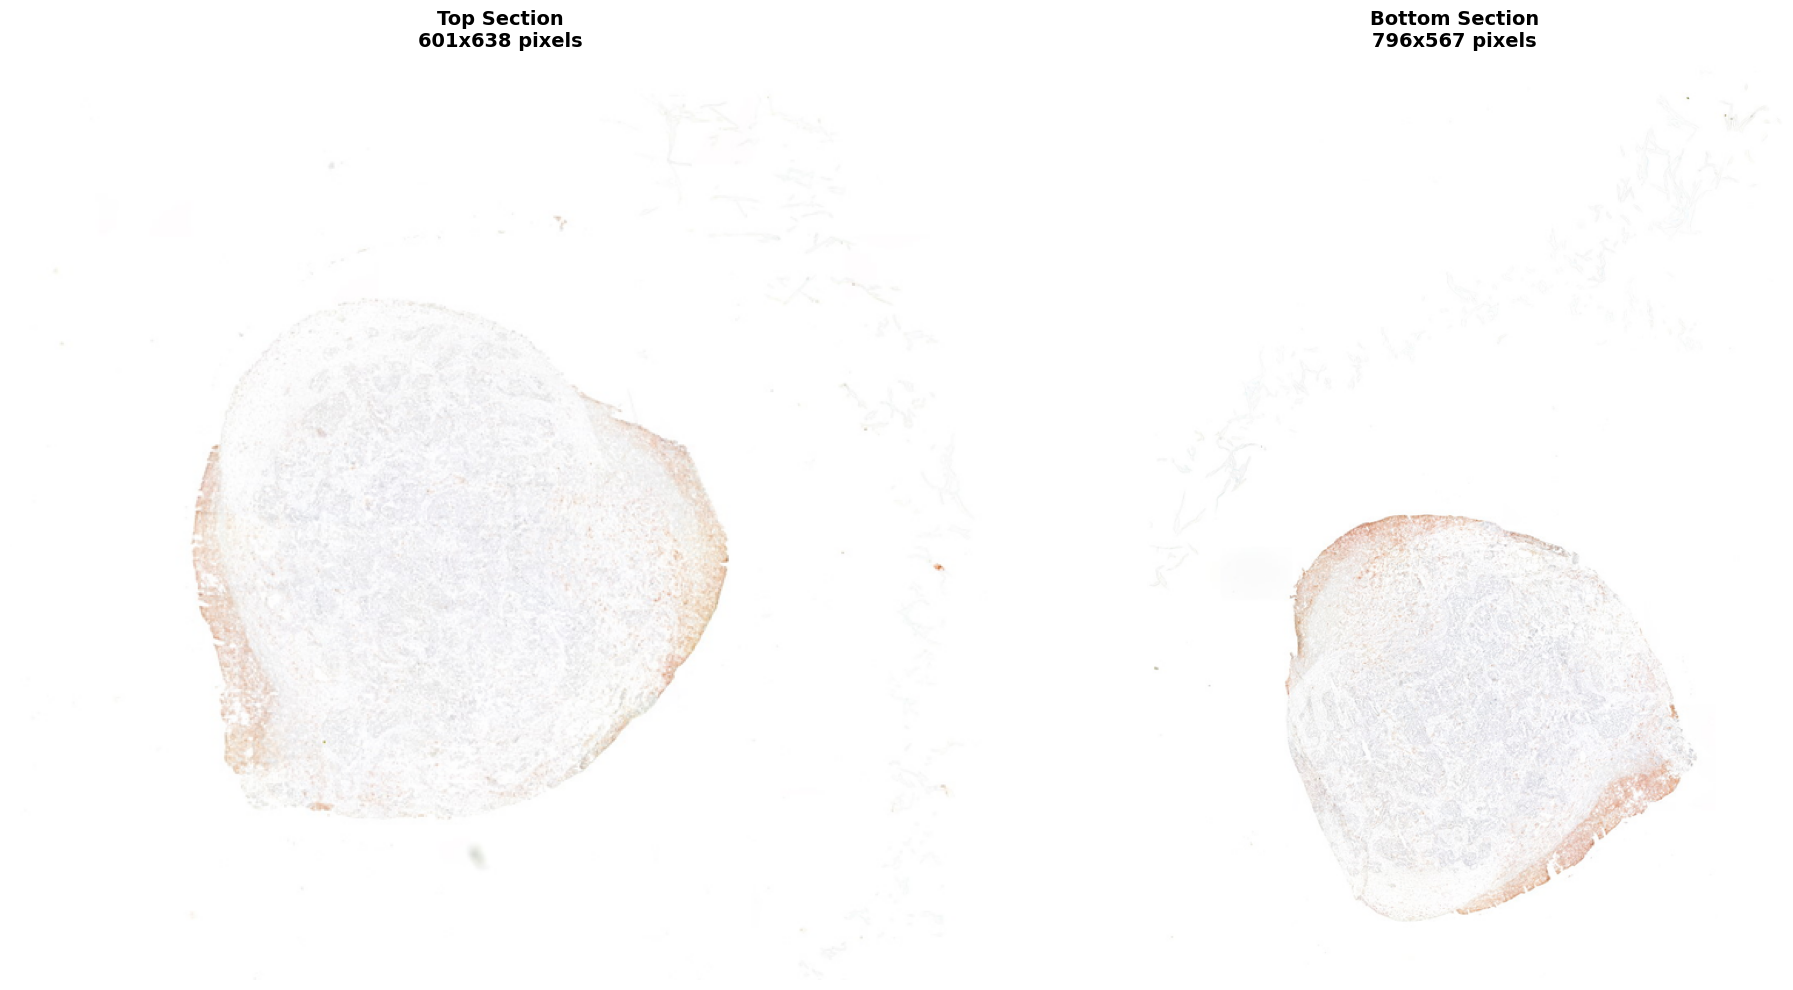

In [37]:
# Test the function with the current slide
test_slide_path = "/storage/research/dbmr_luisierlab/database/Ovarian_Visium_GTOP/IHC/IHC/NAB-HUG-14_C1B2_CD4.mrxs"

top_img, bottom_img, meta = process_dual_tissue_slide(
    test_slide_path, 
    thumbnail_size=(5000, 5000),
    threshold=240,
    margin_percent=5,
    verbose=True
)

# Visualize the results
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(top_img)
axes[0].set_title(f"Top Section\n{top_img.shape[0]}x{top_img.shape[1]} pixels", 
                  fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(bottom_img)
axes[1].set_title(f"Bottom Section\n{bottom_img.shape[0]}x{bottom_img.shape[1]} pixels", 
                  fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Top Section rotated 45°')

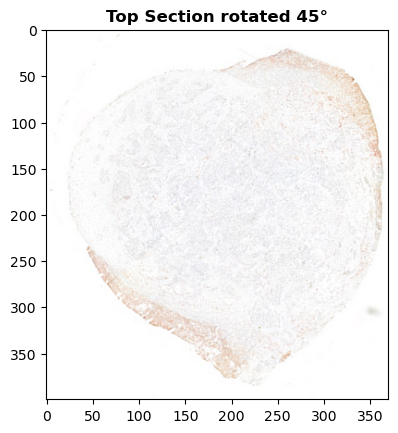

In [44]:
# Convert to PIL, rotate 45 degrees (keep full image) and plot
pil_img = Image.fromarray(top_img)
rotated_pil = pil_img.rotate(45, resample=Image.BICUBIC, expand=True, fillcolor=(255,255,255))
rotated_np_3 = np.array(rotated_pil)

#plt.figure(figsize=(8, 8))
rotated_np_3 = rotated_np_3[300:700, 230:600]
plt.imshow(rotated_np_3)
plt.title("Top Section rotated 45°", fontweight='bold')
# plt.xlim(0, rotated_np.shape[1])
# plt.ylim(rotated_np.shape[0], 0)


In [45]:
test_slide_path = "/storage/research/dbmr_luisierlab/database/Ovarian_Visium_GTOP/IHC/IHC/NAB-HUG-03_C1B1_CD4.mrxs"

top_img, bottom_img, meta = process_dual_tissue_slide(
    test_slide_path, 
    thumbnail_size=(5000, 5000),
    threshold=240,
    margin_percent=5,
    verbose=True
)

Processing: NAB-HUG-03_C1B1_CD4.mrxs
Original dimensions: (102912, 215552)
Thumbnail size: (5000, 2387, 3)

Split at row 2500
  Top half: (2500, 2387, 3)
  Bottom half: (2500, 2387, 3)

--- Cropping top section ---
  Original size: 2500x2387
  Tissue bounding box: rows 541-1642, cols 604-1512
  Cropped size: 1101x908
  Margin added: 50 rows, 41 cols (5%)

--- Cropping bottom section ---
  Original size: 2500x2387
  Tissue bounding box: rows 536-1540, cols 520-1577
  Cropped size: 1004x1057
  Margin added: 45 rows, 48 cols (5%)

Processing complete!
  Top image: (1101, 908, 3)
  Bottom image: (1004, 1057, 3)


Text(0.5, 1.0, 'Top Section rotated 45°')

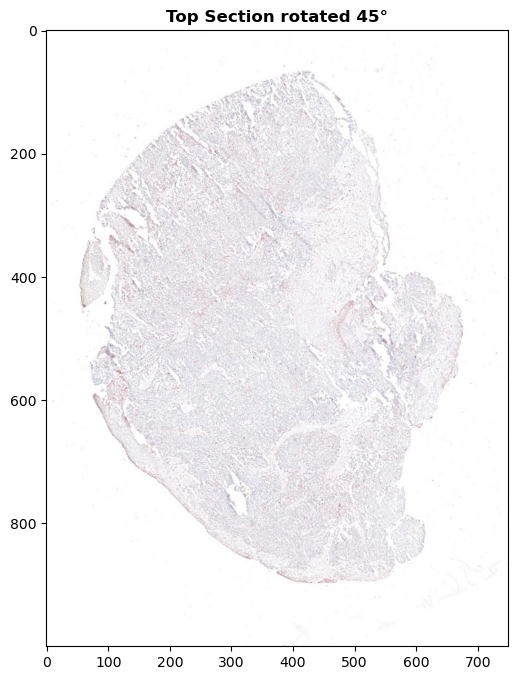

In [49]:
# Convert to PIL, rotate 45 degrees (keep full image) and plot
pil_img = Image.fromarray(top_img)
rotated_pil = pil_img.rotate(25, resample=Image.BICUBIC, expand=True, fillcolor=(255,255,255))
rotated_np = np.array(rotated_pil)

rotated_np = rotated_np[200:1200,250:1000]
plt.figure(figsize=(8, 8))
plt.imshow(rotated_np)
plt.title("Top Section rotated 45°", fontweight='bold')

(1000.0, 0.0)

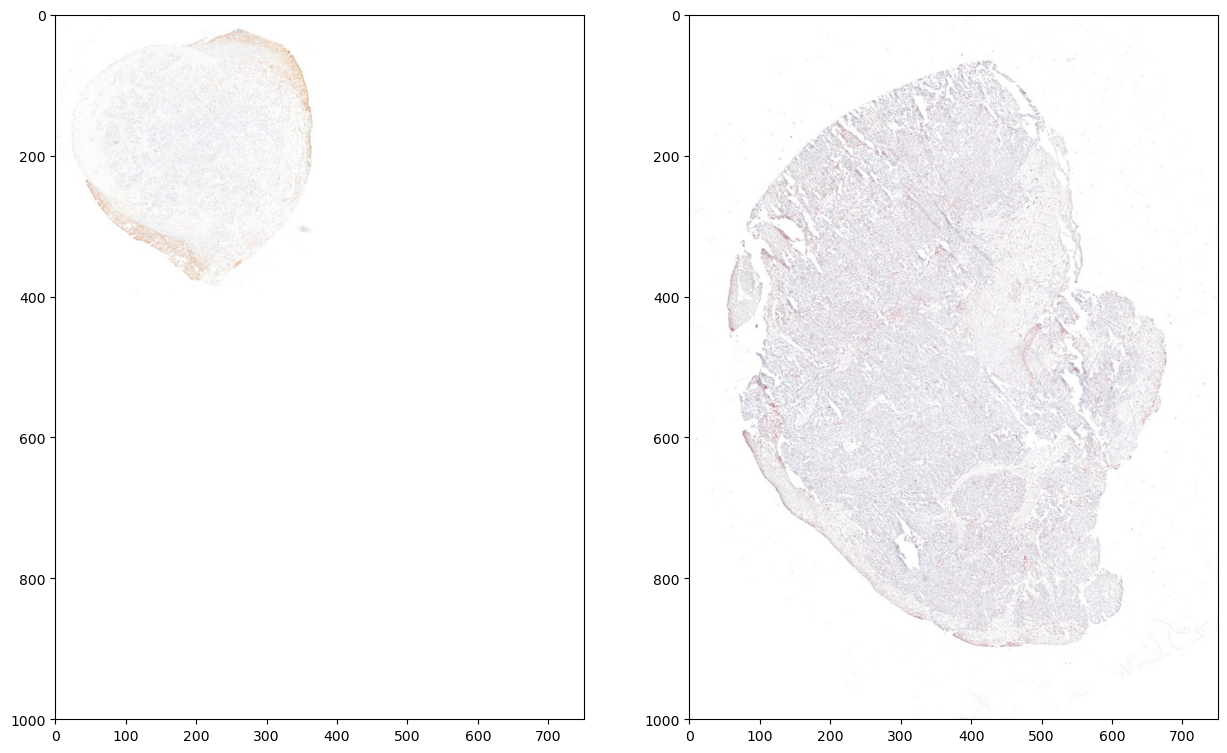

In [50]:
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.imshow(rotated_np_3)
plt.xlim(0, rotated_np.shape[1])
plt.ylim(rotated_np.shape[0], 0)

plt.subplot(1, 2, 2)
plt.imshow(rotated_np)
plt.xlim(0, rotated_np.shape[1])
plt.ylim(rotated_np.shape[0], 0)

In [ ]:
# Convert to PIL, rotate 45 degrees (keep full image) and plot
pil_img = Image.fromarray(top_img)
rotated_pil = pil_img.rotate(30, resample=Image.BICUBIC, expand=True, fillcolor=(255,255,255))
rotated_np = np.array(rotated_pil)

#plt.figure(figsize=(8, 8))
rotated_np = rotated_np[250:1150, 300:1000]
plt.imshow(rotated_np)
plt.title("Top Section rotated 45°", fontweight='bold')
plt.xlim(0, rotated_np.shape[1])
plt.ylim(rotated_np.shape[0], 0)

In [6]:
# Example: Process multiple slides in batch
import glob

# Get all .mrxs files in the IHC directory
ihc_dir = "/storage/research/dbmr_luisierlab/database/Ovarian_Visium_GTOP/IHC/IHC"
slide_files = sorted(glob.glob(os.path.join(ihc_dir, "*.mrxs")))

print(f"Found {len(slide_files)} slide files:")
for i, f in enumerate(slide_files, 1):
    print(f"  {i}. {os.path.basename(f)}")

# Process all slides
results = {}

for slide_file in slide_files:
    slide_name = os.path.basename(slide_file).replace('.mrxs', '')
    print(f"\n{'='*80}")
    print(f"Processing slide {len(results)+1}/{len(slide_files)}: {slide_name}")
    print('='*80)
    
    try:
        top, bottom, metadata = process_dual_tissue_slide(
            slide_file,
            thumbnail_size=(5000, 5000),
            threshold=240,
            margin_percent=5,
            verbose=True
        )
        
        results[slide_name] = {
            'top_image': top,
            'bottom_image': bottom,
            'metadata': metadata
        }
        
    except Exception as e:
        print(f"ERROR processing {slide_name}: {str(e)}")
        results[slide_name] = {'error': str(e)}

print(f"\n\n{'='*80}")
print(f"Batch processing complete!")
print(f"Successfully processed: {sum(1 for v in results.values() if 'error' not in v)}/{len(slide_files)}")
print('='*80)

Found 14 slide files:
  1. NAB-HUG-03_C1B1_CD4.mrxs
  2. NAB-HUG-03_C1_A_CD163.mrxs
  3. NAB-HUG-03_C1_A_CD68.mrxs
  4. NAB-HUG-03_C1_A_CD8.mrxs
  5. NAB-HUG-03_C1_A_Cytokeratin.mrxs
  6. NAB-HUG-03_C1_A_FAP.mrxs
  7. NAB-HUG-03_C1_A_Foxp3.mrxs
  8. NAB-HUG-14_C1B2_CD4.mrxs
  9. NAB-HUG-14_C1_A_CD163.mrxs
  10. NAB-HUG-14_C1_A_CD68.mrxs
  11. NAB-HUG-14_C1_A_CD8.mrxs
  12. NAB-HUG-14_C1_A_FAP.mrxs
  13. NAB-HUG-14_C1_A_Foxp3.mrxs
  14. xNAB-HUG-14_C1_A_Cytokeratin.mrxs

Processing slide 1/14: NAB-HUG-03_C1B1_CD4
Processing: NAB-HUG-03_C1B1_CD4.mrxs
Original dimensions: (102912, 215552)
Thumbnail size: (5000, 2387, 3)

Split at row 2500
  Top half: (2500, 2387, 3)
  Bottom half: (2500, 2387, 3)

--- Cropping top section ---
  Original size: 2500x2387
  Tissue bounding box: rows 541-1642, cols 604-1512
  Cropped size: 1101x908
  Margin added: 50 rows, 41 cols (5%)

--- Cropping bottom section ---
  Original size: 2500x2387
  Tissue bounding box: rows 536-1540, cols 520-1577
  Cropped siz

Thumbnail size: (5000, 2258, 3)

Split at row 2500
  Top half: (2500, 2258, 3)
  Bottom half: (2500, 2258, 3)

--- Cropping top section ---
  Original size: 2500x2258
  Tissue bounding box: rows 1127-1884, cols 875-2059
  Cropped size: 757x1184
  Margin added: 34 rows, 53 cols (5%)

--- Cropping bottom section ---
  Original size: 2500x2258
  Tissue bounding box: rows 858-1972, cols 801-1734
  Cropped size: 1114x933
  Margin added: 50 rows, 42 cols (5%)

Processing complete!
  Top image: (757, 1184, 3)
  Bottom image: (1114, 933, 3)

Processing slide 3/14: NAB-HUG-03_C1_A_CD68
Processing: NAB-HUG-03_C1_A_CD68.mrxs
Original dimensions: (102912, 227840)
Thumbnail size: (5000, 2258, 3)

Split at row 2500
  Top half: (2500, 2258, 3)
  Bottom half: (2500, 2258, 3)

--- Cropping top section ---
  Original size: 2500x2258
  Tissue bounding box: rows 1054-1886, cols 893-1651
  Cropped size: 832x758
  Margin added: 37 rows, 34 cols (5%)

--- Cropping bottom section ---
  Original size: 2500x225

In [7]:
import re
from collections import OrderedDict

results.keys()

def _marker(key):
    return key.split('_')[-1]

def _patient_num(key):
    m = re.search(r'NAB-HUG-(\d+)', key)
    return int(m.group(1)) if m else None

# Group keys by marker
groups = {}
for k in results.keys():
    groups.setdefault(_marker(k), []).append(k)

# Build ordered key list: for each marker, sort by patient number (None last) then by key
ordered_keys = []
for marker in sorted(groups.keys()):
    keys = groups[marker]
    keys_sorted = sorted(keys, key=lambda x: (_patient_num(x) is None, _patient_num(x) if _patient_num(x) is not None else float('inf'), x))
    ordered_keys.extend(keys_sorted)

# Create ordered dict and replace results
results = OrderedDict((k, results[k]) for k in ordered_keys)

# Show the new order
list(results.keys())

['NAB-HUG-03_C1_A_CD163',
 'NAB-HUG-14_C1_A_CD163',
 'NAB-HUG-03_C1B1_CD4',
 'NAB-HUG-14_C1B2_CD4',
 'NAB-HUG-03_C1_A_CD68',
 'NAB-HUG-14_C1_A_CD68',
 'NAB-HUG-03_C1_A_CD8',
 'NAB-HUG-14_C1_A_CD8',
 'NAB-HUG-03_C1_A_Cytokeratin',
 'xNAB-HUG-14_C1_A_Cytokeratin',
 'NAB-HUG-03_C1_A_FAP',
 'NAB-HUG-14_C1_A_FAP',
 'NAB-HUG-03_C1_A_Foxp3',
 'NAB-HUG-14_C1_A_Foxp3']

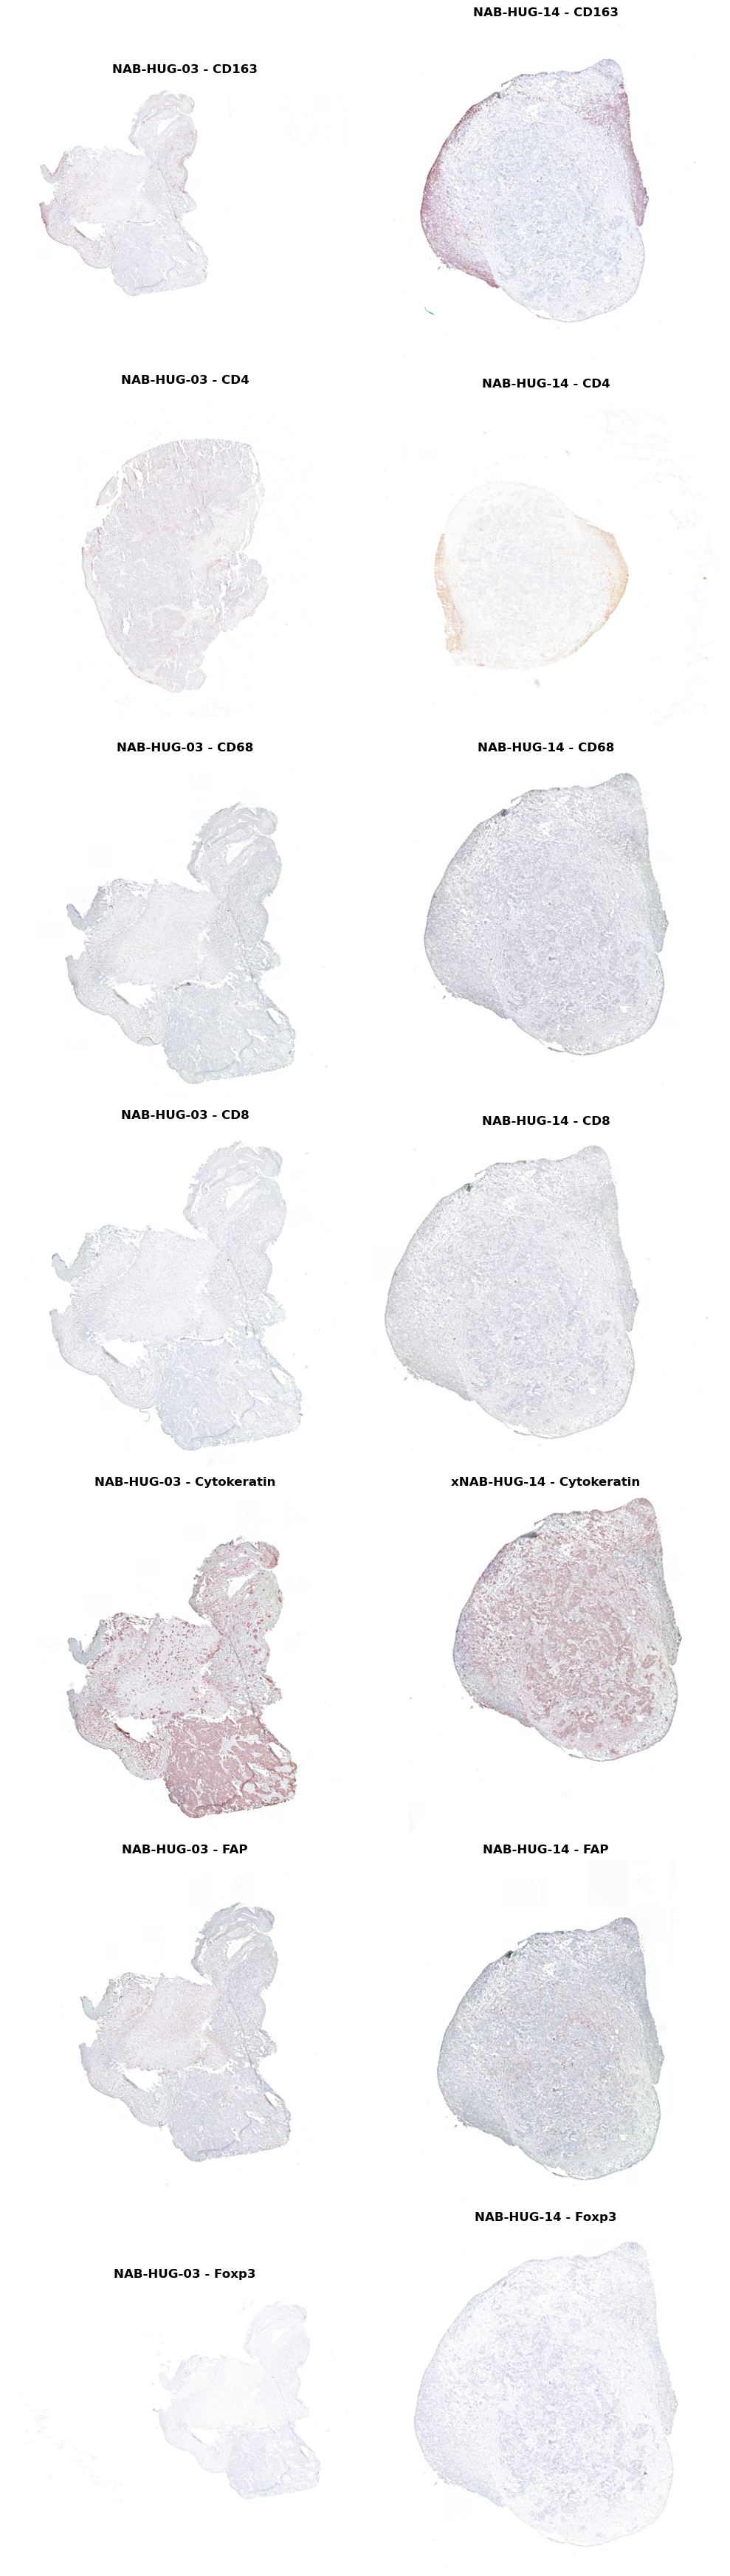

In [8]:
plt.figure(figsize=(10, 7*5))
i = 1
for key, images in results.items():
    plt.subplot(7, 2, i)
    if key == "NAB-HUG-14_C1_A_CD163":
        plt.imshow(images['top_image'][750:1250,1050:1500])
    elif key == "xNAB-HUG-14_C1_A_Cytokeratin":
        plt.imshow(images['top_image'][750:1250,100:500])
    else:
        plt.imshow(images['top_image'])
    plt.title(f"{key.split('_')[0]} - {key.split('_')[-1]}", weight='bold')
    plt.axis("off")
    i = i + 1
plt.tight_layout()


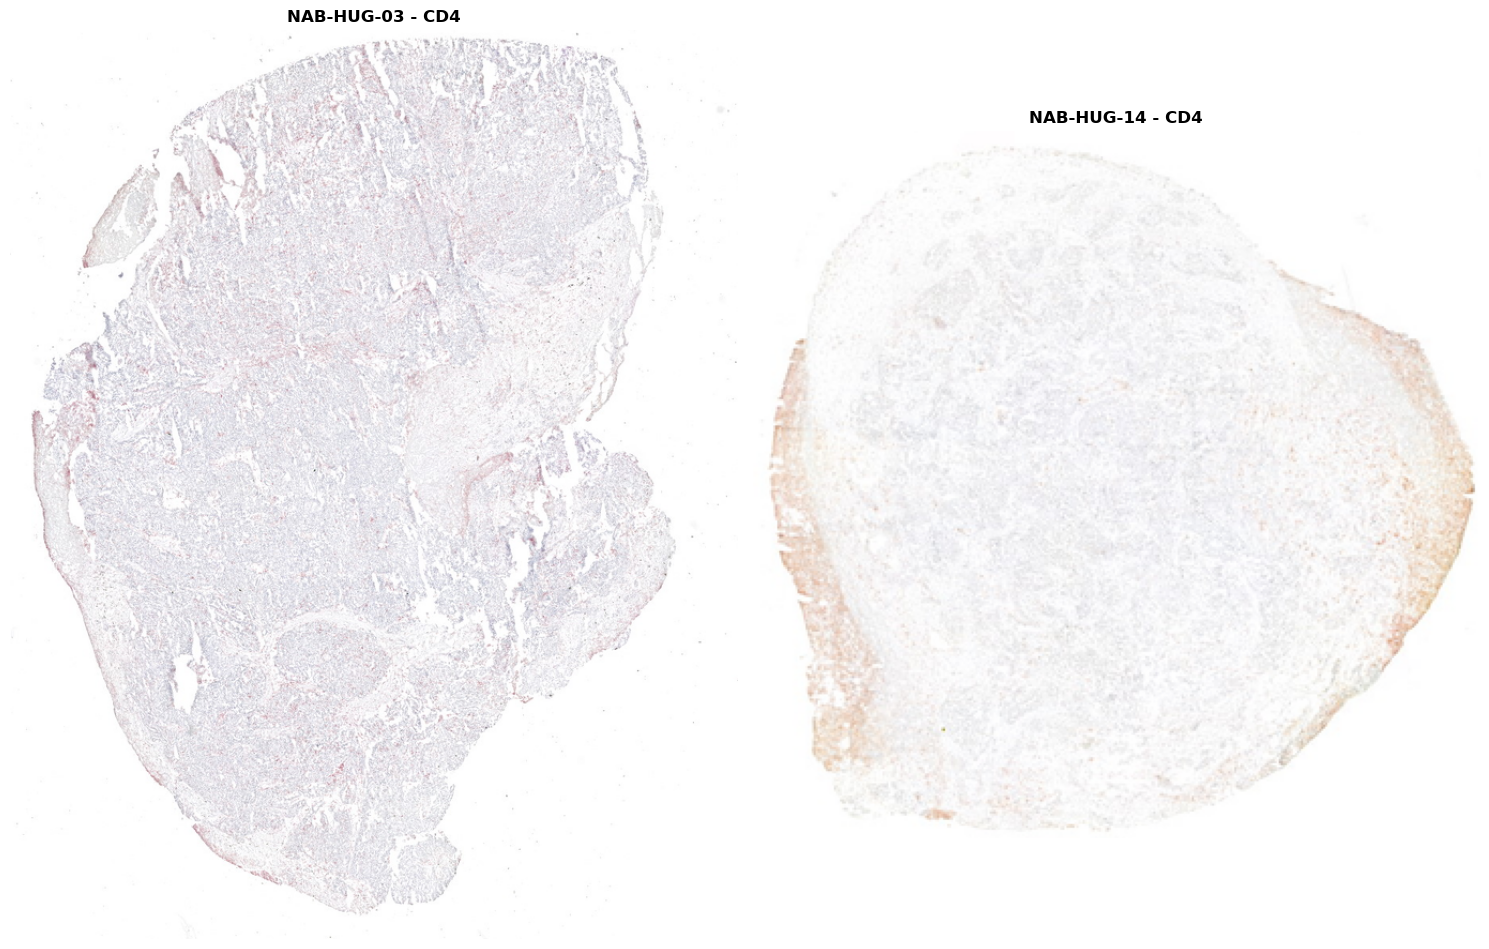

In [9]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
key = "NAB-HUG-03_C1B1_CD4"
plt.imshow(results[key]['top_image'][150:1000,100:780])
plt.title(f"{key.split('_')[0]} - {key.split('_')[-1]}", weight='bold')
plt.axis("off")

plt.subplot(1, 2, 2)
key = 'NAB-HUG-14_C1B2_CD4'
plt.imshow(results[key]['top_image'][150:500,110:470])
plt.title(f"{key.split('_')[0]} - {key.split('_')[-1]}", weight='bold')
plt.axis("off")
plt.tight_layout()

 'NAB-HUG-03_C1B1_CD4',
 'NAB-HUG-14_C1B2_CD4',

In [10]:
# Get the gene expression maps 
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np

## Patient 14
path_to_fullres_img_14 = "/storage/research/dbmr_luisierlab/database/Ovarian_Visium_GTOP/Visium_HD/HE_high_res_NAB-HUG-14/NAB-HUG-14_HE_Visium3_Scan1.qptiff"
slide_14 = openslide.OpenSlide(path_to_fullres_img_14)
thumbnail_14 = slide_14.get_thumbnail(slide_14.dimensions)
spot_dim_14 = 16 / (10000 / float(slide_14.properties.get('tiff.YResolution', 0)))
black_image_14 = np.zeros((thumbnail_14.size[1], thumbnail_14.size[0], 3), dtype=np.uint8)
emb_14 = ad.read_h5ad("A1_NAB_HUG_14_adata_016um_coding_with_positions.h5ad")
## Patient 03
path_to_fullres_img_03 = "/storage/research/dbmr_luisierlab/database/Ovarian_Visium_GTOP/Visium_HD/HE_high_res_NAB-HUG-03/NAB-HUG-03_HE_Visium3_Scan1.qptiff"
slide_03 = openslide.OpenSlide(path_to_fullres_img_03)
thumbnail_03 = slide_03.get_thumbnail(slide_03.dimensions)
spot_dim_03 = 16 / (10000 / float(slide_03.properties.get('tiff.YResolution', 0)))
black_image_03 = np.zeros((thumbnail_03.size[1], thumbnail_03.size[0], 3), dtype=np.uint8)
emb_03 = ad.read_h5ad("D1_NAB_HUG_03_adata_016um_coding_with_positions.h5ad")





/storage/homefs/lf25x455/.conda/envs/digitalhisto/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/storage/homefs/lf25x455/.conda/envs/digitalhisto/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/storage/homefs/lf25x455/.conda/envs/digitalhisto/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/storage/homefs/lf25x455/.conda/envs/digitalhisto/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [16]:
spot_dim_14 = 16 / (10000 / float(slide_14.properties.get('tiff.YResolution', 0)))

In [19]:
(10000 / float(slide_14.properties.get('tiff.YResolution', 0)))

0.24921260779938023

In [18]:
100 / (10000 / float(slide_14.properties.get('tiff.YResolution', 0)))

401.2638079711499

In [11]:
def get_gene_expression_map(emb, black_image, spot_dim, gene_name, ax=None):
    
    if gene_name in emb.var_names:
        gene_idx = emb.var_names.get_loc(gene_name)
        expression_values = np.array(emb.X[:, gene_idx].todense()).flatten()

            # Create colormap normalization
        vmin = expression_values.min()
        vmax = expression_values.max()
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
        cmap = cm.get_cmap('summer')  # You can change to 'plasma', 'inferno', 'magma', etc.

        # Create figure
        #fig, ax = plt.subplots(figsize=(10, 10))

        # instead of showing thumbnail show a full black image of same dimension
        ax.imshow(black_image)
        # Plot spots with color representing expression
        for i, (idx, row) in enumerate(emb.obs.iterrows()):
            expr_value = expression_values[i]
            if expr_value > 0:  # Only show spots with expression
                x = row['pxl_col_in_fullres']
                y = row['pxl_row_in_fullres']
                color = cmap(norm(expr_value))
                rect = plt.Rectangle((x-spot_dim/2, y-spot_dim/2), spot_dim, spot_dim, 
                                    edgecolor='none', facecolor=color, alpha=1)
                ax.add_patch(rect)

        # Add colorbar
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label(f'{gene_name} Expression', rotation=270, labelpad=20, fontweight='bold')

        plt.title(f"{gene_name} Expression Map", fontweight='bold', fontsize=14)

In [12]:
list(set([k.split('_')[-1] for k in results.keys()]))

['CD163', 'CD8', 'FAP', 'CD4', 'Foxp3', 'Cytokeratin', 'CD68']

In [13]:
emb_14.var_names.get_loc("CD68")

14704

Gene expression map for marker: FOXP3


/tmp/ipykernel_4028693/3156561581.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('summer')  # You can change to 'plasma', 'inferno', 'magma', etc.


Gene expression map for marker: CD163
Gene expression map for marker: KRT7
Gene expression map for marker: KRT20
Gene expression map for marker: FAP
Gene expression map for marker: CD4
Gene expression map for marker: CD68


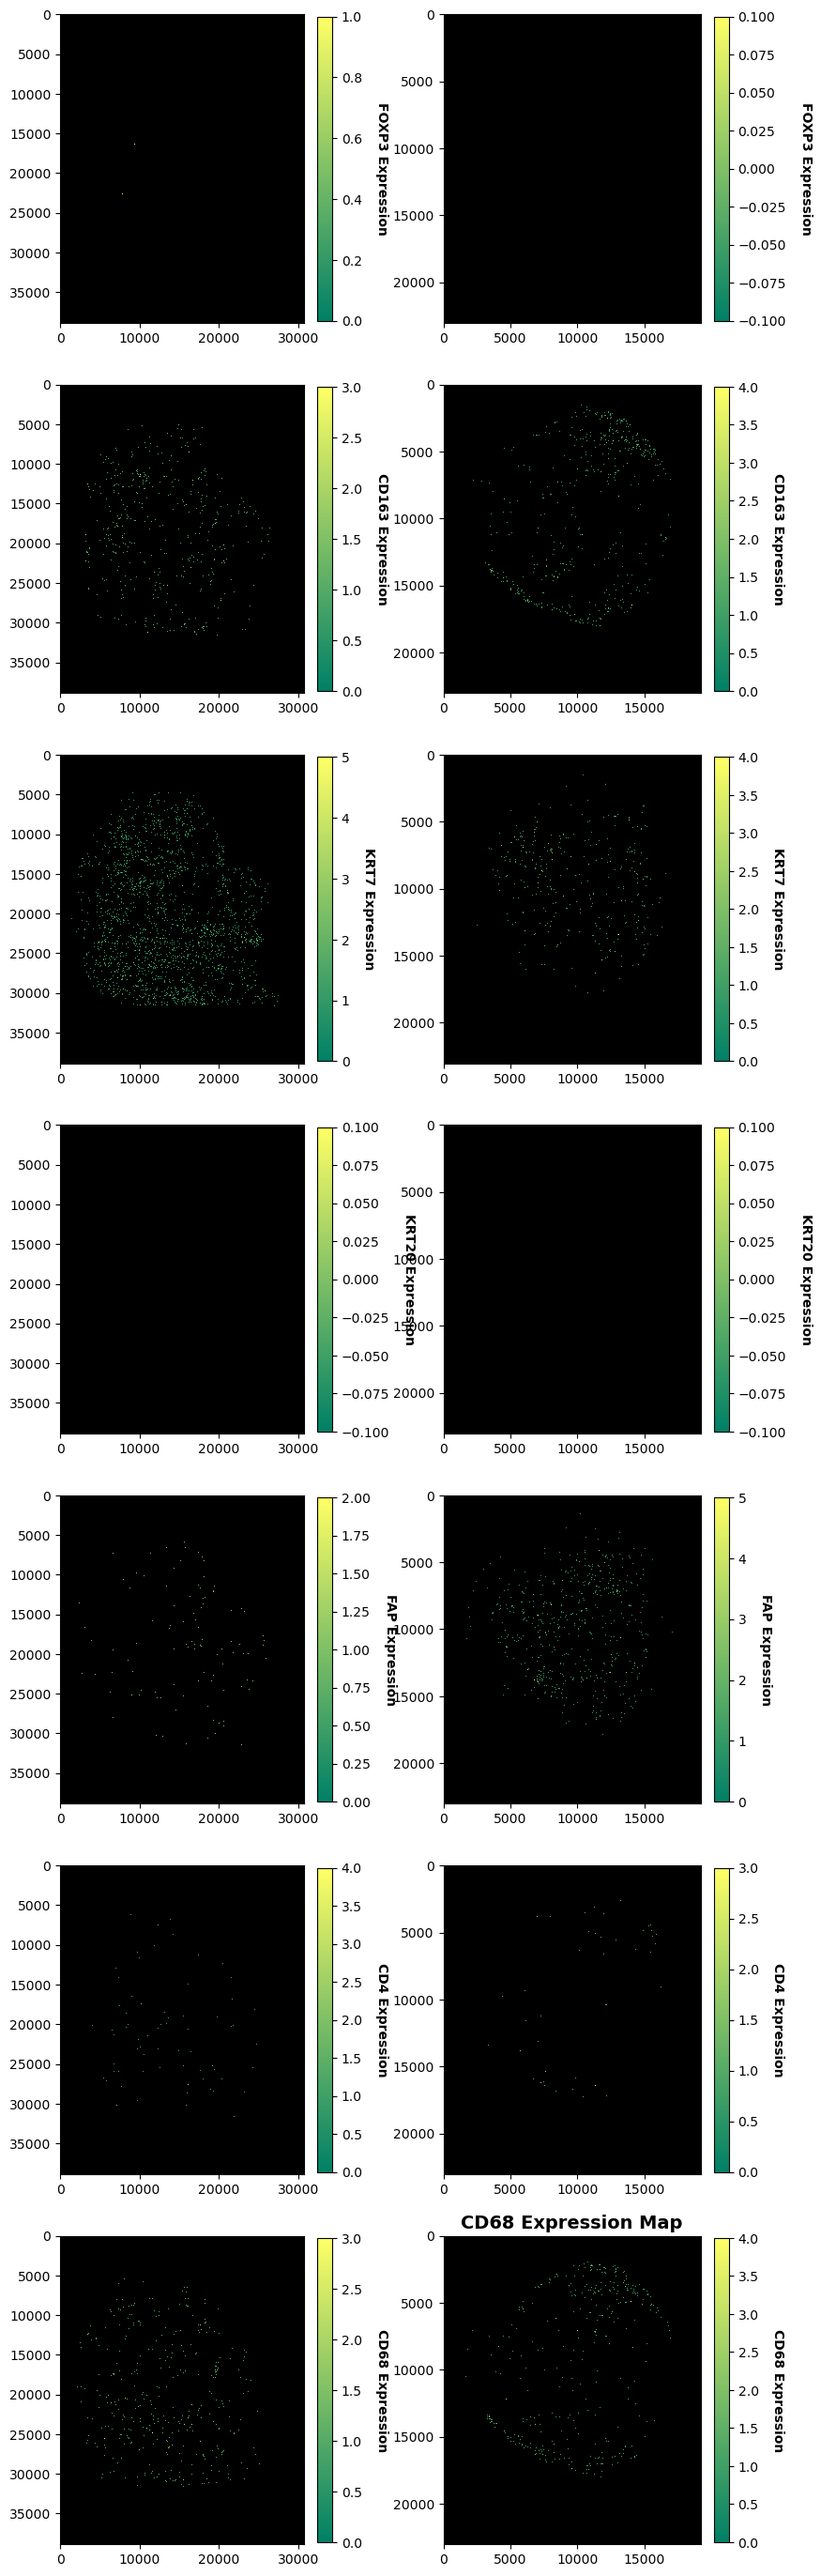

In [14]:
fig, ax = plt.subplots(7, 2, figsize=(10, 7*5))

for i, markers in enumerate(["FOXP3", "CD163", "KRT7", "KRT20", "FAP", "CD4", "CD68"]):
    print(f"Gene expression map for marker: {markers}")
    get_gene_expression_map(emb_03, black_image_03, spot_dim_03, markers, ax=ax[i, 0])
    get_gene_expression_map(emb_14, black_image_14, spot_dim_14, markers, ax=ax[i, 1])


In [15]:
100 / 0.2

500.0